# Bayesian sampling of the posterior distribution

The posterior distribution is defined over the set of structural ensembles with the same functional form as the optimal solution of Ensemble Refinement, parametrized by $\vec\lambda$. Alternatively, you could also have a set of structural ensembles given by some free/flexible coefficients of a force-field correction, or the most general variational freedom of ensembles defined over an arbitrary n. of frames.

The posterior distribution is given by the exponential of minus the loss function.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from basic_functions_bayesian import local_density, compute_single, compute
from basic_functions_bayesian import run_Metropolis, block_analysis

In [3]:
alpha = 0.2  # the hyperparameter of Ensemble Refinement

## arbitrary form of probability distribution
to complete

In [4]:
import jax
import jax.numpy as jnp

In [9]:
def gaussian(x, pars):
    p = 1/jnp.sqrt(2*jnp.pi*pars[0])*jnp.exp(-x**2/(2*pars[0]))
    # p = 1/jnp.sqrt(2*jnp.pi*pars[1])*jnp.exp(-((x - pars[0])**2)/(2*pars[1]))
    return p

In [6]:
def log_gaussian(x, pars):
    log_p = -1/2*jnp.log(2*jnp.pi*pars[1]) - (x - pars[0])**2/(2*pars[1])
    return log_p

In [10]:
xs = np.array([-10, -9.5])

pars = np.array([1.0])

In [11]:
fun_forces = jax.jacfwd(log_gaussian, argnums=1)

pars = np.array([0.0, 1.0])

# xs = np.linspace(-10, 10, 100)
xs = np.array([-10, -9.5])

ders = np.array(fun_forces(xs, pars))

print(ders)

metric = np.einsum('i,ij,ik->jk', np.exp(log_gaussian(xs, pars)), ders, ders)

triang = np.linalg.cholesky(metric)

np.prod(np.diag(triang))

NameError: name 'log_gaussian' is not defined

In [12]:
def log_p(xs, pars, function):
    return jnp.log(function(xs, pars))

fun_forces = jax.jacfwd(log_p, argnums=1)

# my_fun_forces = lambda x, pars: fun_forces(xs, pars, gaussian)

ders = np.array(fun_forces(xs, pars, gaussian))

print(ders)

# metric = np.einsum('i,ij,ik->jk', np.exp(log_p(xs, pars, gaussian)), ders, ders)
metric = np.einsum('i,ij,ik->jk', gaussian(xs, pars), ders, ders)

triang = np.linalg.cholesky(metric)

jeffreys = np.prod(np.diag(triang))

jeffreys

[[49.5  ]
 [44.625]]


4.500849e-09

In [13]:
def compute_jeffreys(fun_p, fun_forces, xs, pars):

    ders = np.array(fun_forces(xs, pars, fun_p))

    print(ders)

    # metric = np.einsum('i,ij,ik->jk', np.exp(log_p(xs, pars, gaussian)), ders, ders)
    metric = np.einsum('i,ij,ik->jk', fun_p(xs, pars), ders, ders)

    print(metric)

    # triang = np.linalg.cholesky(metric)
    # jeffreys = np.prod(np.diag(triang))

    jeffreys = np.sqrt(np.linalg.det(metric))

    return jeffreys


In [29]:
xs = np.linspace(-2, 2, 1000)

xs

array([-2.        , -1.995996  , -1.99199199, -1.98798799, -1.98398398,
       -1.97997998, -1.97597598, -1.97197197, -1.96796797, -1.96396396,
       -1.95995996, -1.95595596, -1.95195195, -1.94794795, -1.94394394,
       -1.93993994, -1.93593594, -1.93193193, -1.92792793, -1.92392392,
       -1.91991992, -1.91591592, -1.91191191, -1.90790791, -1.9039039 ,
       -1.8998999 , -1.8958959 , -1.89189189, -1.88788789, -1.88388388,
       -1.87987988, -1.87587588, -1.87187187, -1.86786787, -1.86386386,
       -1.85985986, -1.85585586, -1.85185185, -1.84784785, -1.84384384,
       -1.83983984, -1.83583584, -1.83183183, -1.82782783, -1.82382382,
       -1.81981982, -1.81581582, -1.81181181, -1.80780781, -1.8038038 ,
       -1.7997998 , -1.7957958 , -1.79179179, -1.78778779, -1.78378378,
       -1.77977978, -1.77577578, -1.77177177, -1.76776777, -1.76376376,
       -1.75975976, -1.75575576, -1.75175175, -1.74774775, -1.74374374,
       -1.73973974, -1.73573574, -1.73173173, -1.72772773, -1.72

In [16]:
compute_jeffreys(gaussian, fun_forces, xs, jnp.array([1.5]))

[[ 0.5555555 ]
 [ 0.20438954]
 [-0.05898495]
 [-0.23456793]
 [-0.3223594 ]
 [-0.3223594 ]
 [-0.23456793]
 [-0.05898495]
 [ 0.20438954]
 [ 0.5555555 ]]
[[0.16415413]]


0.40515938

In [30]:
sigma2s = 10**(np.linspace(-2, 2, 30))

jeff = {}

for sigma2 in sigma2s:
    jeff[sigma2] = compute_jeffreys(gaussian, fun_forces, xs, np.array([sigma2]))

[[            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [            nan]
 [          

/u/i/igilardo/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[[ 1.56205652e+03]
 [ 1.55575220e+03]
 [ 1.54946045e+03]
 [ 1.54318140e+03]
 [ 1.53691504e+03]
 [ 1.53066101e+03]
 [ 1.52441992e+03]
 [ 1.51819128e+03]
 [ 1.51197534e+03]
 [ 1.50577209e+03]
 [ 1.49958142e+03]
 [ 1.49340344e+03]
 [ 1.48723804e+03]
 [ 1.48108545e+03]
 [ 1.47494519e+03]
 [ 1.46881763e+03]
 [ 1.46270264e+03]
 [ 1.45660071e+03]
 [ 1.45051099e+03]
 [ 1.44443408e+03]
 [ 1.43836975e+03]
 [ 1.43231799e+03]
 [ 1.42627905e+03]
 [ 1.42025269e+03]
 [ 1.41423877e+03]
 [ 1.40823755e+03]
 [ 1.40224902e+03]
 [ 1.39627332e+03]
 [ 1.39031006e+03]
 [ 1.38435938e+03]
 [ 1.37842139e+03]
 [ 1.37249622e+03]
 [ 1.36658337e+03]
 [ 1.36068323e+03]
 [ 1.35479578e+03]
 [ 1.34892114e+03]
 [ 1.34305884e+03]
 [ 1.33720935e+03]
 [ 1.33137244e+03]
 [ 1.32554810e+03]
 [ 1.31973657e+03]
 [ 1.31393750e+03]
 [ 1.30815112e+03]
 [ 1.30237732e+03]
 [ 1.29661633e+03]
 [ 1.29086792e+03]
 [ 1.28513196e+03]
 [ 1.27940894e+03]
 [ 1.27369824e+03]
 [ 1.26800024e+03]
 [ 1.26231494e+03]
 [ 1.25664233e+03]
 [ 1.2509824

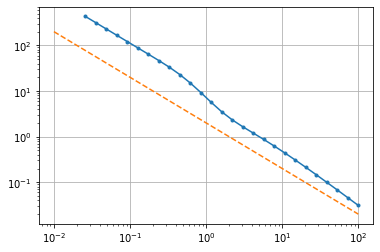

In [34]:
plt.plot(sigma2s, [jeff[k] for k in jeff.keys()], '.-')
plt.plot(sigma2s, 2/sigma2s, '--')
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [137]:
mus = np.array([0])  # np.linspace(-10, 10, 30)
sigma2s = 10**(np.linspace(-2, 2, 30))

xs = np.linspace(-2, 2, 100)
# sigmas = np.array([1e-1])

jeff = {}

for mu in mus:
    jeff[mu] = {}
    print(mu)
    for sigma in sigma2s:
        jeff[mu][sigma] = compute_jeffreys(gaussian, fun_forces, xs, np.array([mu, sigma]))


0
[[            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]
 [-1.31313141e+02  8.57156934e+03]
 [-1.27272720e+02  8.04917285e+03]
 [-1.23232338e+02  7.54310400e+03]
 [-1.19191925e+02  7.05335693e+03]
 [-1.15151505e+02  6.57993555e+03]
 [-1.11111130e+02  6.12284033e+03]
 [-1.07070702e+02  5.68206885e+03]
 [-1.03030304e+02  5.25762207e+03]
 [-9.89898987e+01  4.84950049e+03]
 [-9.49495010e+01  4.45770361e+03]
 [-9.09090958e+01  4.08223169e+03]
 [-8.68686905e+01 

/u/i/igilardo/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


[[-5.61443253e+01  1.56205652e+03]
 [-5.50101013e+01  1.49901917e+03]
 [-5.38758698e+01  1.43726868e+03]
 [-5.27416344e+01  1.37680408e+03]
 [-5.16074104e+01  1.31762610e+03]
 [-5.04731865e+01  1.25973511e+03]
 [-4.93389549e+01  1.20313013e+03]
 [-4.82047272e+01  1.14781165e+03]
 [-4.70704994e+01  1.09377966e+03]
 [-4.59362679e+01  1.04103430e+03]
 [-4.48020363e+01  9.89575134e+02]
 [-4.36678085e+01  9.39402710e+02]
 [-4.25335808e+01  8.90516663e+02]
 [-4.13993454e+01  8.42917053e+02]
 [-4.02651253e+01  7.96603943e+02]
 [-3.91308899e+01  7.51577271e+02]
 [-3.79966621e+01  7.07837219e+02]
 [-3.68624420e+01  6.65383545e+02]
 [-3.57282066e+01  6.24216309e+02]
 [-3.45939789e+01  5.84335632e+02]
 [-3.34597511e+01  5.45741333e+02]
 [-3.23255196e+01  5.08433533e+02]
 [-3.11912937e+01  4.72412262e+02]
 [-3.00570660e+01  4.37677490e+02]
 [-2.89228344e+01  4.04229034e+02]
 [-2.77886047e+01  3.72067230e+02]
 [-2.66543770e+01  3.41191864e+02]
 [-2.55201511e+01  3.11602936e+02]
 [-2.43859196e+01  2

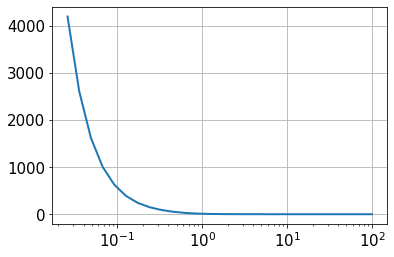

In [141]:
plt.plot(sigma2s, flatten(jeff))
plt.xscale('log')
# plt.yscale('log')
plt.grid()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


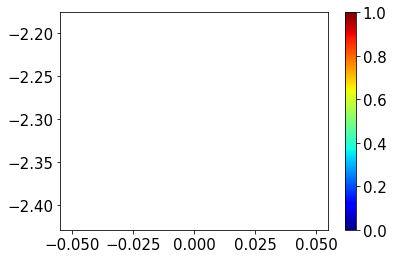

In [129]:
flatten = lambda jeff: np.array([[jeff[l1][l2] for l1 in mus] for l2 in sigmas])


plt.figure()
plt.pcolormesh(mus, np.log(sigmas), flatten(jeff), cmap='jet')
plt.colorbar()

In [55]:
def log_p(xs, pars, function):
    return jnp.log(function(xs, pars))

fun_forces = jax.jacfwd(log_p, argnums=1)

ders = np.array(fun_forces(xs, pars, gaussian))

p = gaussian(xs, pars)
# p = np.exp(log_p(xs, pars, gaussian))

metric = np.einsum('i,ji,ki->jk', p, ders, ders)

triang = np.linalg.cholesky(metric)
measure = np.prod(np.diag(triang))

print(measure)

6.0624876


In [88]:
pars0 = np.array([0.0, 1.0])
xs = np.linspace(-10, 10, 100)
# lambdas0 = np.array([30.0])

def proposal(pars, dpars = 0.01):
    pars_new = pars + dpars*np.random.normal(size=len(pars))
    return pars_new

proposal_full = {'fun': proposal, 'args': ([0.01])}

def log_p(xs, pars, function):
    return jnp.log(function(xs, pars))

fun_derivatives = jax.jacfwd(log_p, argnums=1)

def energy_fun(pars, xs, function_p, function_ders):

    ders = np.array(function_ders(xs, pars, gaussian))

    p = function_p(xs, pars)
    # p = np.exp(log_p(xs, pars, gaussian))

    metric = np.einsum('i,ij,ik->jk', p, ders, ders)

    triang = np.linalg.cholesky(metric)
    
    # measure = np.prod(np.diag(triang))
    # energy = -np.log(measure)

    energy = -np.sum(np.diag(triang))
    
    return energy, None

In [89]:
energy_function = {'fun': energy_fun, 'args': ([xs, gaussian, fun_forces])}
out_J = run_Metropolis(pars0, proposal_full, energy_function, n_steps=1000)

0
100
200
300
400
500
600
700
800
900


0.993


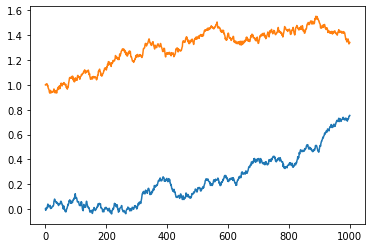

In [90]:
plt.plot(out_J[0])

print(out_J[2])

## 1st example: single experimental observable
i.e. 1-dimensional distribution

- 1 for small n. of frames and user-defined observable
- 2 for higher n. of frames
- 3 for two peaks
- 4 for almost flat

In [4]:
which_case = 4

if which_case == 1:

    n = 2  # number of frames

    # probability distribution:
    p0 = [3/4, 1/4]
    p0 = p0/np.sum(p0)

    # value of the observable at these points:
    g = np.array([0, 1])

    # experimental value and error of the observable
    gexp = 0.9
    sigma = 0.2

elif which_case == 2:
    
    n = 60  # n. frames

    p0 = np.random.dirichlet(np.ones(n), size=n)[:, 0]
    
    x = np.random.normal(1, 0.2, size=n)
    g = x**2

    gexp = 1.5
    sigma = 0.3

elif which_case == 3:

    var = 0.02
    n = 25

    if not np.mod(n, 2) == 0: n += 1

    g = np.concatenate([np.random.normal(0, np.sqrt(var), size=n//2), np.random.normal(1, np.sqrt(var), size=n//2)])

    p0 = np.ones(n)
    p0 /= np.sum(p0)

    gexp = 0.8
    sigma = 0.1

elif which_case == 4:
    
    n = 100000

    # p0 = np.random.dirichlet(np.ones(n), size=None)
    p0 = np.ones(n)/n
    
    # x = np.random.normal(0, 0.1, size=n)
    x = np.random.normal(0, 0.5, size=n)
    g = x# **2

    gexp = 1.7  # 0.3
    sigma = 0.6  # 0.02

### compute and plot
as a function of lambda

Text(0.5, 0, 'n frames')

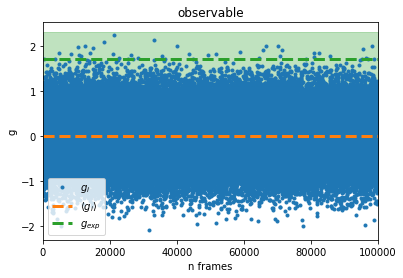

In [5]:
plt.rcParams['lines.linewidth'] = 3

plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma, gexp - sigma], [gexp + sigma, gexp + sigma], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

# plt.savefig('../Figures/ex1_obs.pdf', format='pdf', bbox_inches='tight')

In [6]:
dlambda = 1e-1
lambdamax = 100
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)

# lambdas = np.linspace(-lambdamax, lambdamax, n)

In [7]:
out = compute_single(0.3, p0, g, gexp, sigma, alpha)

vars(out).keys()

dict_keys(['P', 'Z', 'av_g', 'av_g2', 'var_g', 'std_g', 'chi2', 'Srel', 'lossf', 'gamma', 'jeffreys', 'cov', 'dirichlet', 'avg_density'])

In [8]:
results = compute(lambdas, p0, g, gexp, sigma, alpha)

results.keys()

dict_keys(['P', 'Z', 'av_g', 'av_g2', 'var_g', 'std_g', 'chi2', 'Srel', 'lossf', 'gamma', 'jeffreys', 'cov', 'dirichlet', 'avg_density'])

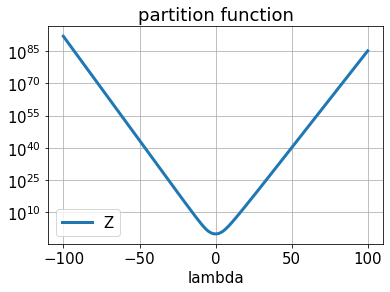

In [9]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

plt.plot(lambdas, results['Z'], '-', label='Z')
plt.yscale('log')
plt.xlabel('lambda')
plt.title('partition function')
plt.legend()
plt.grid()

-6.900000000005292


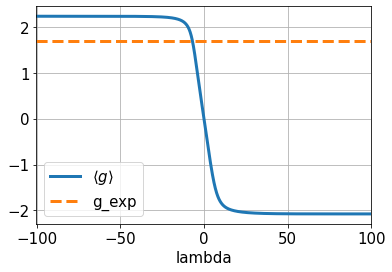

In [10]:
plt.plot(lambdas, results['av_g'], '-', label=r'$\langle g \rangle$')
plt.plot([lambdas[0], lambdas[-1]], [gexp, gexp], '--', label='g_exp')
#plt.yscale('log')
plt.xlabel('lambda')
plt.legend()
plt.grid()
plt.xlim([np.min(lambdas), np.max(lambdas)])

print(lambdas[np.argmin(np.abs(results['av_g'] - gexp))])

# plt.savefig('../Figures/ex1_g_match.pdf', format='pdf', bbox_inches='tight')

-5.200000000005389


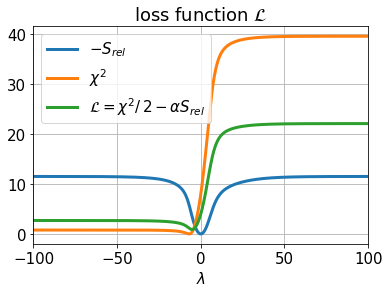

In [11]:
plt.plot(lambdas, -results['Srel'], '-', label=r'$- S_{rel}$')
plt.plot(lambdas, results['chi2'], '-', label=r'$\chi^2$')
plt.plot(lambdas, -alpha*results['Srel'] + 1/2*results['chi2'][:, 0], '-', label=r'$\mathcal{L}=\chi^2/\,2 - \alpha S_{rel}$')

plt.title(r'loss function $\mathcal{L}$')
# plt.yscale('log')
# plt.xlim([-50, 50])
plt.xlabel(r'$\lambda$')
plt.legend()
plt.grid()
plt.xlim([lambdas[0], lambdas[-1]])

# plt.savefig('../Figures/1_loss.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('../Figures/ex1_loss.pdf', format='pdf', bbox_inches='tight')

print(lambdas[np.argmin(results['lossf'])])

in the limit of low (high) $\lambda$, $\lambda \rightarrow -\infty$ ($+\infty$), the limit value of $D_{KL}$ is $-\log P_0(\bar x)$ where $\bar x$ is the frame in which $g(x)$ takes its max (min) value, respectively, and the limit value of $\chi^2$ is $\Bigl(\frac{g(\bar x) - g_{exp}}{\sigma_{exp}}\Bigr)^2$

notice you cannot expand perturbatively $e^{-\lambda (g-g_{max})}$ around $\lambda = -\infty$ (the same for $e^{-\lambda(g - g_{min})}$ around $\lambda = +\infty$)

hence, if the n. of frames is high, the asymptotic value of the loss function is high, and in practice there is no critical issue about normalization of the hyper-ensemble

In [12]:
x_min = np.argwhere(g == np.min(g))[0]
x_max = np.argwhere(g == np.max(g))[0]

lim_values = [-alpha*np.log(p0[x_max]) + 1/2*((np.max(g) - gexp)/sigma)**2,
    -alpha*np.log(p0[x_min]) + 1/2*((np.min(g) - gexp)/sigma)**2]

loss_min = np.min(results['lossf'])

print('exact values: ', lim_values)
print(results['lossf'][0], results['lossf'][-1])

print('min. value of the loss: ', np.min(results['lossf']))

exact values:  [array([2.69262025]), array([22.1027994])]
2.6924502162939117 22.102092991468798
min. value of the loss:  0.8872163806386267


Text(0.5, 1.0, 'ensemble n. density (normalized)')

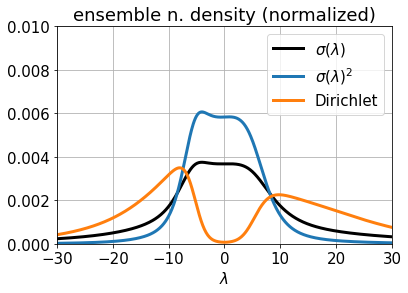

In [13]:
#plt.plot(lambdas,-np.log(std_gs),'-',label='- log std')

normalize = lambda x: x/np.nansum(x)

plt.plot(lambdas, normalize(results['std_g']), '-', label=r'$\sigma(\lambda)$', c='k')
#plt.plot(lambdas,-2*np.log(std_gs),'-',label='- log variance')
#plt.plot(lambdas,-np.log(dirichlets),'-',label='equiv. for Dirichlet')

# plt.plot(lambdas[1:], normalize(np.abs(np.ediff1d(results['av_g'])/np.ediff1d(lambdas))), '-', label=r'$d\langle g\rangle/d\lambda$')
plt.plot(lambdas, normalize(results['std_g']**2), '-', label=r'$\sigma(\lambda)^2$')
plt.plot(lambdas, normalize(results['dirichlet']), '-', label='Dirichlet')

plt.xlabel(r'$\lambda$')
plt.grid()
plt.legend()
#plt.title('volume transformation')
plt.xlim([-30, 30])
# plt.xlim([lambdas[0], lambdas[-1]])
plt.ylim([0, 0.01])
# plt.yscale('symlog')
plt.title('ensemble n. density (normalized)')

# plt.savefig('../Figures/2_density.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('../Figures/ex1_density.pdf', format='pdf', bbox_inches='tight')

So we could say it is quite the same to use $\sigma d\lambda$ or $\sigma^2 d\lambda$, corresponding to measuring distances with Fisher metrics (namely, Jeffreys prior, KL divergence) or with $d\langle g \rangle$, respectively. However, there is the issue of dimensions: are there more ensembles in between 1 and 2 $\mu m$ or in between 1 and 2 $Hz$? It makes no sense, so let's use $\sigma d\lambda$ which is adimensional.

In [14]:
loss = results['lossf']
loss -= np.min(loss)

loss1 = loss - np.log(results['std_g'])
loss1 -= np.nanmin(loss1)

loss2 = loss - 2*np.log(results['std_g'])
loss2 -= np.nanmin(loss2)

gamma = results['gamma']

loss_dir = loss - np.log(results['dirichlet'])
loss_dir -= np.nanmin(loss_dir)

delta = np.min(loss) - np.min(gamma)

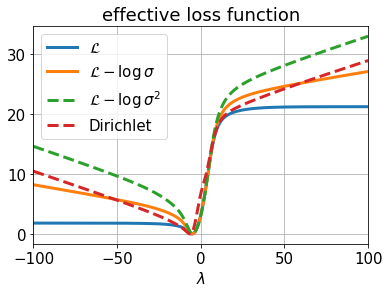

In [15]:
plt.plot(lambdas, loss, '-', label=r'$\mathcal{L}$')  # loss f.')#,markersize=0.5)
plt.plot(lambdas, loss1, '-', label=r'$\mathcal{L}-\log\,\sigma$')
# plt.plot(lambdas,-loss+loss1,'-',label=r'$-\log\sigma$')

plt.plot(lambdas, loss2, '--', label=r'$\mathcal{L}-\log\,\sigma^2$')

# plt.plot(lambdas, gamma, '-', label='gamma f.')

#plt.plot(lambdas,gamma+delta,'-',label='gamma f. +delta')
plt.plot(lambdas, loss_dir, '--', label='Dirichlet')

plt.legend()  # loc='upper left')  # (loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\lambda$')
plt.title('effective loss function')
# plt.yscale('symlog')
# plt.xscale('symlog')

# plt.xlim([-30, 30])
plt.xlim([lambdas[0], lambdas[-1]])
# plt.ylim([-5,40])

plt.grid()

# plt.savefig('../Figures/ex1_eff_loss.pdf', format='pdf', bbox_inches='tight')

In [16]:
xmin_loss = lambdas[np.argwhere(loss == np.min(loss))[0][0]]
xmin_gamma = lambdas[np.argwhere(gamma == np.min(gamma))[0][0]]
xmin_1 = lambdas[np.argwhere(loss1 == np.min(loss1))[0][0]]
xmin_2 = lambdas[np.argwhere(loss2 == np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ', xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)


min. of the "original" loss function:  -5.200000000005389
min. of Gamma function:  -5.200000000005389
min. of the loss f. with std correction:  -5.0000000000054
min. of the loss f. with variance correction:  -4.900000000005406


so, the hyper probability distribution $P(\lambda)$ is:

In [17]:
hyper_P0 = np.exp(-loss)
hyper_P1 = np.exp(-loss1)
hyper_P2 = np.exp(-loss2)
hyper_P_gamma = np.exp(-gamma)
hyper_P_dir = np.exp(-loss_dir)

[0.06770331]
0.16443600108113185
0.16443600108113185


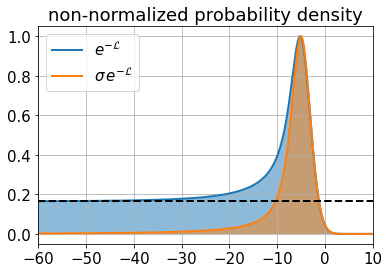

In [18]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15

plt.plot(lambdas, hyper_P0, label=r'$e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)
#plt.plot(lambdas,hyper_P_gamma,label='gamma')

plt.plot(lambdas,hyper_P1,label=r'$\sigma \, e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P1, alpha=0.5)

#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
lim_x = [-60, 10]
plt.xlim(lim_x)
# plt.plot(lim_x, [hyper_P0[0], hyper_P0[0]], '--', linewidth=2)

print(np.exp(-lim_values[0]))

val = np.max(hyper_P0)*np.exp(-results['lossf'][0])

print(val)
print(hyper_P0[0])

plt.plot(lim_x, [val, val], 'k--')
#plt.yscale('log')
plt.grid()
plt.title('non-normalized probability density')
plt.legend(loc='upper left')#(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig('../Figures/ex1_non-norm_loss.pdf', format='pdf', bbox_inches='tight')

In [19]:
hyper_P0 = hyper_P0/np.sum(hyper_P0)
hyper_P1 = hyper_P1/np.sum(hyper_P1)
hyper_P2 = hyper_P2/np.sum(hyper_P2)
hyper_P_gamma = hyper_P_gamma/np.sum(hyper_P_gamma)
hyper_P_dir = hyper_P_dir/np.sum(hyper_P_dir)

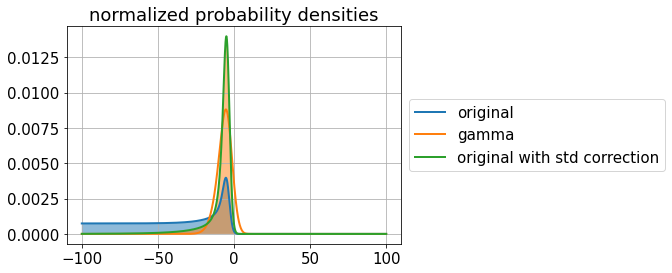

In [20]:
plt.plot(lambdas, hyper_P0, label='original')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)

plt.plot(lambdas, hyper_P_gamma, label='gamma')

plt.plot(lambdas, hyper_P1, label='original with std correction')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P1, alpha=0.5)

#plt.plot(lambdas,hyper_P2,label='original with variance correction')
#plt.plot(lambdas,hyper_P_dir,label='original with Dirichlet correction')
# plt.xlim([-30, 30])
#plt.yscale('log')
plt.grid()
plt.title('normalized probability densities')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Metropolis sampling

In [21]:
lambdas0 = np.zeros(1)
# lambdas0 = np.array([30.0])

# def proposal(x0, dx = 0.01):
#     x_new = x0 + dx*np.random.normal(size=len(x0))
#     return x_new

# proposal_full = {'fun': proposal, 'args': ([0.5])}
proposal_std = 0.5

def energy_fun(lambdas, which_measure = None):
    """implicit input parameters: p0, g, gexp, sigma, alpha"""
    
    out = compute_single(lambdas, p0, g, gexp, sigma, alpha)
    
    energy = out.lossf
    quantities = [out.av_g, out.Srel]

    if which_measure is not None: energy -= np.log(vars(out)[which_measure])
    
    return energy, quantities

In [23]:
energy_function = lambda x : energy_fun(x, 'jeffreys')
out_J = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=5000)

energy_function = lambda x : energy_fun(x, None)
out_noJ = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=5000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


/u/i/igilardo/5_Jeffreys/Jeffreys_prior/basic_functions_bayesian.py:463: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  else: return np.array(traj), np.array(ene), av_alpha, np.array(quantities)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [24]:
print('acceptance: ', out_J[2], out_noJ[2])

acceptance:  0.9416 0.9556


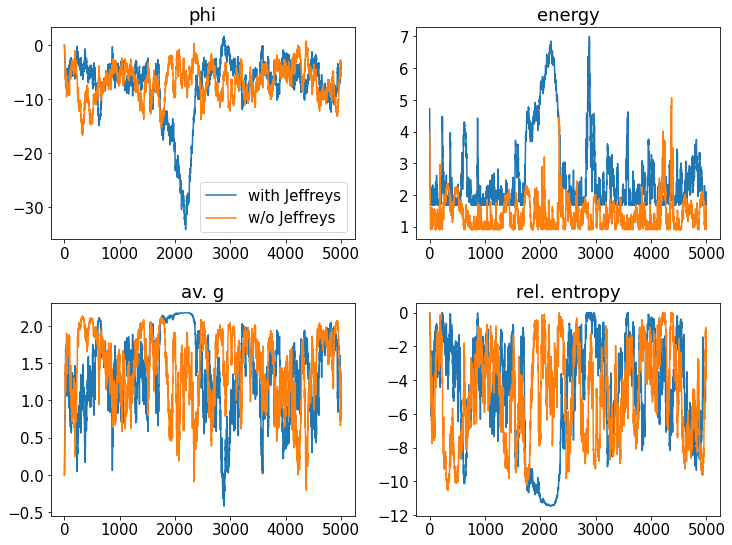

In [25]:
plt.rcParams['lines.linewidth'] = 1.5

fig, axs = plt.subplots(2, 2, figsize=(12, 9))

axs[0, 0].plot(out_J[0], label='with Jeffreys')
axs[0, 0].plot(out_noJ[0], label='w/o Jeffreys')
axs[0, 0].set_title('phi')
axs[0, 0].legend()

axs[0, 1].plot(out_J[1])
axs[0, 1].plot(out_noJ[1])
axs[0, 1].set_title('energy')

axs[1, 0].plot(out_J[3][:, 0])
axs[1, 0].plot(out_noJ[3][:, 0])
axs[1, 0].set_title('av. g')

axs[1, 1].plot(out_J[3][:, 1])
axs[1, 1].plot(out_noJ[3][:, 1])
axs[1, 1].set_title('rel. entropy')

fig.subplots_adjust(hspace=0.3)

# plt.savefig('../Figures/ex1_Metropolis.pdf', format='pdf', bbox_inches='tight')

In [26]:
av_J = np.mean(out_J[3][:, 0], axis=0)
# av_J_new = np.mean(out_J_new[3], axis=0)
av_noJ = np.mean(out_noJ[3][:, 0], axis=0)

print('averages: ', av_J, av_noJ)

# here you should use block analysis
std_J = np.std(out_J[3][:, 0], axis=0)/np.sqrt(len(out_J[3][:, 0]))
# std_J_new = np.std(out_J_new[3], axis=0)/np.sqrt(len(out_J_new[3]))
std_noJ = np.std(out_noJ[3][:, 0], axis=0)/np.sqrt(len(out_noJ[3][:, 0]))

print('std: ', std_J, std_noJ)

order_par = (np.sum((av_J - av_noJ)**2/(std_J**2 + std_noJ**2)))
print(order_par)

averages:  [1.38276892] [1.44551076]
std:  [0.00749648] [0.0066692]
39.10124256917004


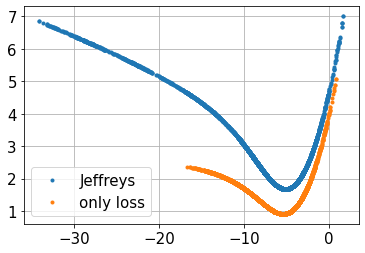

In [27]:
plt.plot(out_J[0], out_J[1], '.', label='Jeffreys')
# plt.plot(out_J_new[0], out_J_new[1], 'd', label='Jeffreys, adaptive MC')
plt.plot(out_noJ[0], out_noJ[1], '.', label='only loss')
plt.legend()
plt.grid()

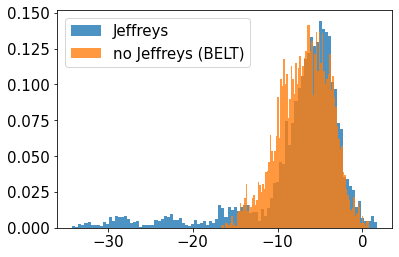

In [28]:
plt.hist(out_J[0], bins=100, alpha=0.8, density=True, label='Jeffreys')
# plt.hist(out_J_new[0], bins=100, alpha=0.8, density=True, label='Jeffreys, adaptive MC')
plt.hist(out_noJ[0], bins=100, alpha=0.8, density=True, label='no Jeffreys (BELT)')
#plt.hist(traj3,bins=100)

plt.legend()

#### wrong Metropolis sampling

In [ ]:
lambdas0 = np.zeros(1)
# lambdas0 = np.array([30.0])

def proposal(x0, dx = 0.01, which_measure = 'jeffreys'):

    r = np.random.normal(size=len(x0))

    if which_measure == 'jeffreys':
        out = compute_single(x0, p0, g, gexp, sigma, alpha)
        r = np.einsum('ij,j', out.cov, r)

    x_new = x0 + dx*r

    return x_new

proposal_full = {'fun': proposal, 'args': ([0.5, 'jeffreys'])}

def energy_fun(lambdas, a):
    """implicit input parameters: g, gexp, sigma, alpha"""
    
    out = compute_single(lambdas, p0, g, gexp, sigma, alpha)
    
    energy = out.lossf
    av_g = out.av_g

    return energy, av_g

In [ ]:
energy_function = {'fun': energy_fun, 'args': ([None])}
out_J_new = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=50000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

### almost flat - cycle over different n. of frames

to see the difference asymptotic value - min. as a function of the n. of frames

In [59]:
dlambda = 1e-1
lambdamax = 20
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)

ns = [10, 20, 50, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5]

if_remove = False  # if True, remove frames with g > g_exp

how_many = []
vals = []

for n in ns:

    n = np.int(n)

    p0 = np.random.dirichlet(np.ones(n), size=None)

    x = np.random.normal(1, 0.2, size=n)
    g = x**2

    gexp = 3.2
    sigma = 0.3

    wh = np.where(g > gexp)[0]
    how_many.append(len(wh))

    if if_remove:
        g = np.delete(g, wh)
        p0 = np.delete(p0, wh)

    print(how_many[-1])

    results = compute(lambdas, p0, g, gexp, sigma, alpha)

    x_min = np.argwhere(g == np.min(g))[0]
    x_max = np.argwhere(g == np.max(g))[0]

    lim_values = [-alpha*np.log(p0[x_max]) + 1/2*((np.max(g) - gexp)/sigma)**2,
        -alpha*np.log(p0[x_min]) + 1/2*((np.min(g) - gexp)/sigma)**2]

    print('exact values: ', lim_values)
    print(results['lossf'][0], results['lossf'][-1])

    print('min. value of the loss: ', np.min(results['lossf']))

    diff = np.min(lim_values - np.min(results['lossf']))
    print('diff: ', diff)

    vals.append(lim_values + [results['lossf'][0], results['lossf'][-1], np.min(results['lossf']), diff])


0
exact values:  [array([18.43471242]), array([44.70946859])]
18.767716879543357 44.69639347752086
min. value of the loss:  18.767716879543357
diff:  -0.3330044610285512
0
exact values:  [array([12.09554254]), array([41.78972195])]
12.219125874321932 39.611949946587224
min. value of the loss:  12.219125874321932
diff:  -0.12358333730694504
0
exact values:  [array([4.48337697]), array([44.62148274])]
4.4844088220240605 43.917058439657325
min. value of the loss:  4.4844088220240605
diff:  -0.0010318525154699998
0
exact values:  [array([9.13623557]), array([47.98489029])]
10.25498371127482 45.256107278210045
min. value of the loss:  10.25498371127482
diff:  -1.1187481394714691
0
exact values:  [array([5.52726177]), array([52.48989654])]
5.465351286186457 48.06317108386417
min. value of the loss:  5.465351286186457
diff:  0.061910482119433397
0
exact values:  [array([0.65029158]), array([51.01420778])]
0.6502899581270543 47.56750520885942
min. value of the loss:  0.6502340674231821
diff:  

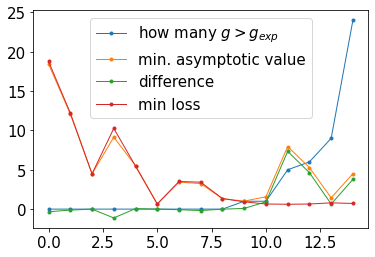

In [60]:
diff = [vals[i][-1] for i in range(len(vals))]

min_asymp = np.array([vals[i][0] for i in range(len(vals))])
max_asymp = np.array([vals[i][1] for i in range(len(vals))])

min_val = np.array([vals[i][4] for i in range(len(vals))])

plt.plot(how_many, '.-', label=r'how many $g > g_{exp}$')
plt.plot(min_asymp, '.-', label='min. asymptotic value')
plt.plot(diff, '.-', label='difference')
plt.plot(min_val, '.-', label='min loss')

# print(min_asymp, max_asymp)
plt.legend()

## 2nd example: some observables
4 peaks

In [92]:
# probability distribution:
p0 = [3, 4, 1, 1]

# normalize, if not normalized
p0 = p0/np.sum(p0)

# value of the observable at these points:
g = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T

# experimental value and error of the observable
gexp = [0.1, 0.8]
sigma = [0.2, 0.1]

print(p0.shape, g.shape)

(4,) (2, 4)


In [93]:
var = 0.1/30  # spread of the 4 peaks (assumption: the same for all)
how_many = 200  # times prop, it gives the population of the 4 peaks
prop = [1, 1, 1, 1]  # chosen proportion of the 4 peaks

g = np.concatenate((np.random.multivariate_normal(mean=(0, 0), cov=var*np.diag([1, 1]), size=prop[0]*how_many),
    np.random.multivariate_normal(mean=(0, 1), cov=var*np.diag([1, 1]), size=prop[1]*how_many),
    np.random.multivariate_normal(mean=(1, 0), cov=var*np.diag([1, 1]), size=prop[2]*how_many),
    np.random.multivariate_normal(mean=(1, 1), cov=var*np.diag([1, 1]), size=prop[3]*how_many))).T

p0 = np.ones(len(g.T))  # different n. of points in each Gaussian
p0 = p0/np.sum(p0)

gexp = [0.1, 0.8]
sigma = [0.2, 0.1]

[0.1, 0.8] [0.2, 0.1]


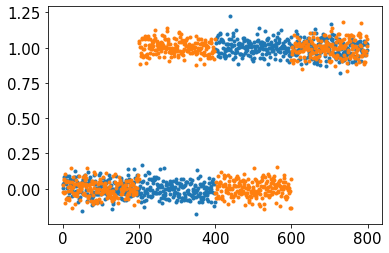

In [94]:
plt.plot(g.T, '.')

print(gexp, sigma)

# plt.plot([-5, len(g.T) + 5], [np.mean(g.T), np.mean(g.T)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

# plt.plot([-5, len(g.T) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
# plt.fill_between([-5, len(g) + 5], [gexp - sigma, gexp - sigma], [gexp + sigma, gexp + sigma], alpha=0.3, color='tab:green')


In [95]:
lambda_i = [1, 1]

out = compute_single(lambda_i, p0, g, gexp, sigma, alpha)

vars(out)

{'P': array([0.0025102 , 0.00272042, 0.0025266 , 0.00241327, 0.00238677,
        0.0026902 , 0.00281136, 0.00232313, 0.00239909, 0.00277659,
        0.00262135, 0.0028287 , 0.0027293 , 0.0028783 , 0.00249757,
        0.00240342, 0.00261163, 0.00298364, 0.00248592, 0.00246793,
        0.00265465, 0.00262734, 0.00229037, 0.00267874, 0.0026285 ,
        0.00309033, 0.00251623, 0.00272848, 0.00248292, 0.00258535,
        0.00251828, 0.00273514, 0.00292152, 0.00228376, 0.0025536 ,
        0.00270548, 0.00266797, 0.00268048, 0.00267956, 0.0029697 ,
        0.00235546, 0.0026584 , 0.00255967, 0.00264158, 0.00284082,
        0.00273603, 0.00271191, 0.0025984 , 0.00273012, 0.00274268,
        0.00246184, 0.00304666, 0.00229731, 0.00270741, 0.00259757,
        0.00236082, 0.00253421, 0.0026822 , 0.0022795 , 0.00252391,
        0.00242359, 0.00259097, 0.00275238, 0.00240251, 0.00320148,
        0.00248958, 0.00288949, 0.00259851, 0.00296157, 0.00244727,
        0.00245236, 0.0023731 , 0.00283274,

In [96]:
lambdas = np.linspace(-30, 30, 100)

my_grid = np.meshgrid(lambdas, lambdas)

out = {}

for l1 in lambdas:
    out[l1] = {}
    for l2 in lambdas:
        out[l1][l2] = vars(compute_single(np.array([l1, l2]), p0, g, gexp, sigma, alpha))

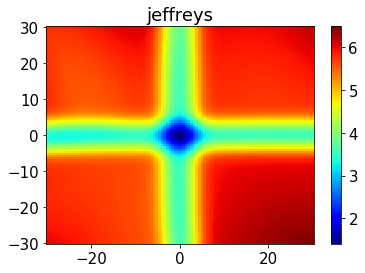

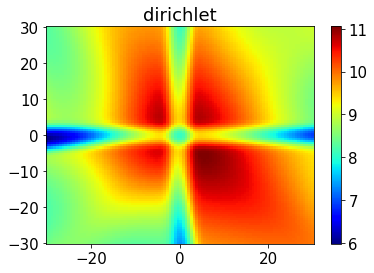

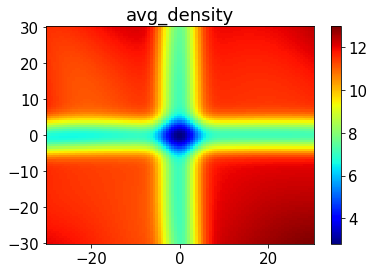

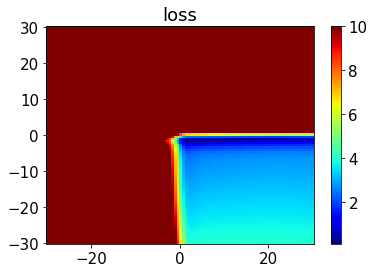

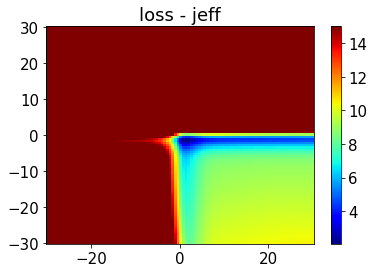

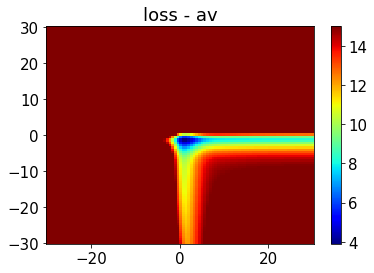

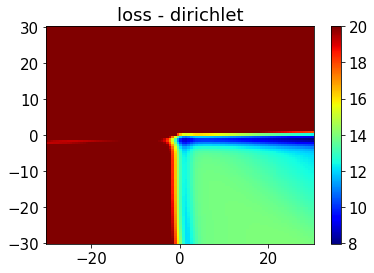

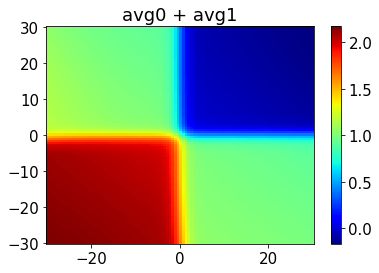

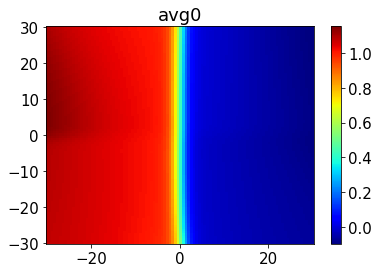

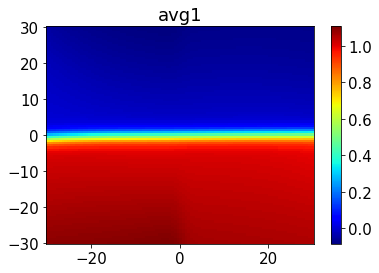

In [97]:
matplotlib.rcParams['pcolor.shading'] = 'auto'

flatten = lambda out, s: np.array([[out[l1][l2][s] for l1 in lambdas] for l2 in lambdas])

loss = flatten(out, 'lossf')

avgs = flatten(out, 'av_g')
avg0 = avgs[:, :, 0]
avg1 = avgs[:, :, 1]

# plt.imshow(lambdas, lambdas, loss, 'jet')
# plt.pcolormesh(lambdas, lambdas, loss, cmap='jet')
for s in ['jeffreys', 'dirichlet', 'avg_density']:
    plt.figure()
    plt.pcolormesh(lambdas, lambdas, -np.log(flatten(out, s)), cmap='jet')
    plt.title(s)
    plt.colorbar()

plt.figure()
plt.title('loss')
plt.pcolormesh(lambdas, lambdas, loss, cmap='jet', vmax=10)
plt.colorbar()

plt.figure()
plt.title('loss - jeff')
plt.pcolormesh(lambdas, lambdas, loss - np.log(flatten(out, 'jeffreys')), cmap='jet', vmax=15)
plt.colorbar()

plt.figure()
plt.title('loss - av')
plt.pcolormesh(lambdas, lambdas, loss - np.log(flatten(out, 'avg_density')), cmap='jet', vmax=15)
plt.colorbar()

plt.figure()
plt.title('loss - dirichlet')
plt.pcolormesh(lambdas, lambdas, loss - np.log(flatten(out, 'dirichlet')), cmap='jet', vmax=20)
plt.colorbar()

plt.figure()
plt.title('avg0 + avg1')
plt.pcolormesh(lambdas, lambdas, avg0 + avg1, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg0')
plt.pcolormesh(lambdas, lambdas, avg0, cmap='jet')
plt.colorbar()

plt.figure()
plt.title('avg1')
plt.pcolormesh(lambdas, lambdas, avg1, cmap='jet')
plt.colorbar()
plt.show()

- does the Jeffreys prior go to zero for high $|\lambda|$?

In [98]:
lambdas_long = np.linspace(-500, 500, 1000)

for l1 in lambdas_long:
    out[l1] = vars(compute_single(np.array([l1, lambdas[len(lambdas)//2]]), p0, g, gexp, sigma, alpha))


/u/i/igilardo/5_Jeffreys/Jeffreys_prior/basic_functions_bayesian.py:291: RuntimeWarning: invalid value encountered in sqrt
  density = np.sqrt(np.linalg.det(cov))
/u/i/igilardo/5_Jeffreys/Jeffreys_prior/basic_functions_bayesian.py:337: RuntimeWarning: invalid value encountered in sqrt
  density = np.sqrt(np.linalg.det(metric))


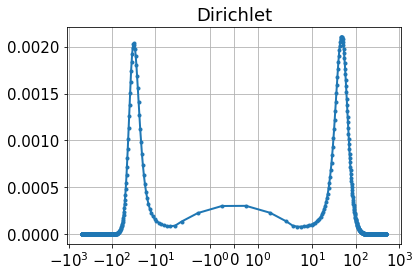

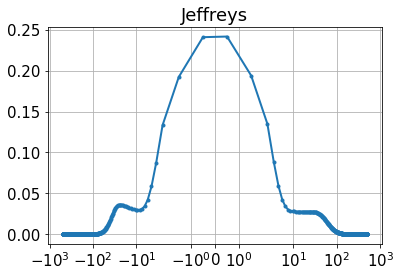

In [99]:
vec = [out[l2]['dirichlet'] for l2 in lambdas_long]
plt.plot(lambdas_long, vec, '.-')
plt.title('Dirichlet')
plt.xscale('symlog')
plt.grid()

plt.figure()
vec = [out[l2]['jeffreys'] for l2 in lambdas_long]
plt.plot(lambdas_long, vec, '.-')
plt.title('Jeffreys')
plt.xscale('symlog')
plt.grid()

### Metropolis sampling

In [285]:
lambdas0 = np.zeros(2)

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.5])}

def energy_fun(lambdas, which_measure = None):
    
    out = compute_single(lambdas, p0, g, gexp, sigma, alpha)
    
    energy = out.lossf

    quantities = [out.av_g, out.Srel]

    if which_measure is not None:
        measure = local_density(g.T, out.P, which_measure=which_measure)[0]
        energy -= np.log(measure)
    
    return energy, quantities

In [286]:
type(energy_fun)

function

In [101]:
which_measures = [None, 'jeffreys', 'average', 'dirichlet']

out = {}

for which_measure in which_measures:
    energy_function = {'fun': energy_fun, 'args': ([which_measure])}
    out[which_measure] = run_Metropolis(lambdas0, proposal_full, energy_function, n_steps=10000)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0


/u/i/igilardo/5_Jeffreys/Jeffreys_prior/basic_functions_bayesian.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  else: return np.array(traj), np.array(ene), av_alpha, np.array(quantities)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
600


In [102]:
print('acceptance: ', [(wm, out[wm][2]) for wm in out.keys()])

acceptance:  [(None, 0.8908), ('jeffreys', 0.7913), ('average', 0.6672), ('dirichlet', 0.7674)]


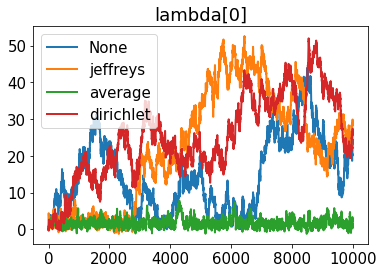

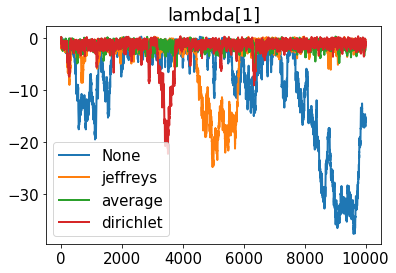

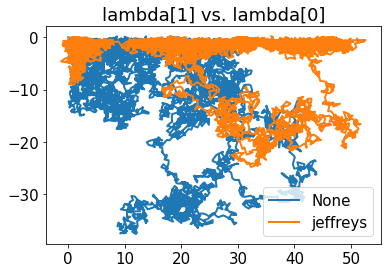

In [117]:
plt.figure()

for wm in out.keys():
    plt.plot(out[wm][0][:, 0], label=str(wm))
    plt.title('lambda[0]')
plt.legend()

plt.figure()

for wm in out.keys():
    plt.plot(out[wm][0][:, 1], label=str(wm))
    plt.title('lambda[1]')
plt.legend()

plt.figure()
for wm in [None, 'jeffreys']:  # out.keys():
    plt.plot(out[wm][0][:, 0], out[wm][0][:, 1], label=str(wm))
    plt.title('lambda[1] vs. lambda[0]')
plt.legend()

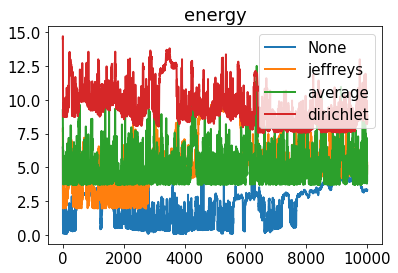

In [104]:
plt.figure()

for wm in out.keys():
    plt.plot(out[wm][1], label=str(wm))

plt.title('energy')
plt.legend()

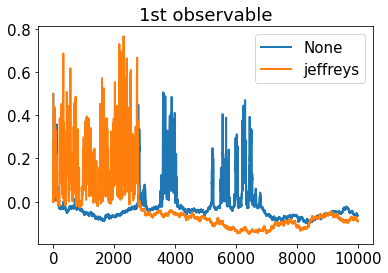

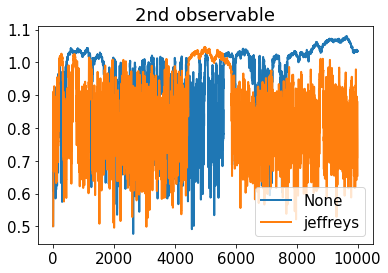

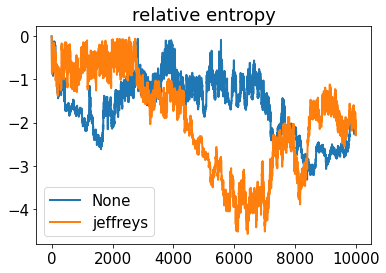

In [114]:
qs = {}

plot_keys = list(out.keys())  # plot just some keys to see better
plot_keys = [plot_keys[0], plot_keys[1]]

for wm in out.keys():
    qs[wm] = np.array([np.hstack(out[wm][3][i]) for i in range(len(out[wm][3]))]).T

for wm in plot_keys:
    # plt.figure()
    plt.plot(qs[wm][0], label=str(wm))

plt.title('1st observable')
plt.legend()

plt.figure()
for wm in plot_keys:
    # plt.figure()
    plt.plot(qs[wm][1], label=str(wm))
    plt.title(wm)

plt.title('2nd observable')
plt.legend()

plt.figure()
for wm in plot_keys:
    # plt.figure()
    plt.plot(qs[wm][2], label=str(wm))
    plt.title(wm)

plt.title('relative entropy')
plt.legend()

ValueError: setting an array element with a sequence.

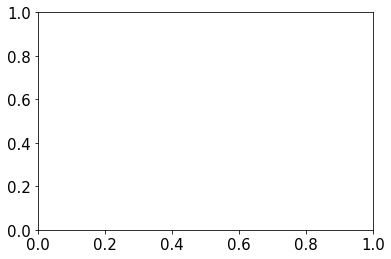

In [115]:
wm = 'jeffreys'

for wm in [None, 'dirichlet', 'jeffreys', 'average']:
    plt.figure()
    plt.plot(out[wm][3][:, 0], out[wm][3][:, 1], '.', alpha=0.5)

    plt.xlabel('1st observable')
    plt.ylabel('2nd observable')
    plt.title(str(wm))



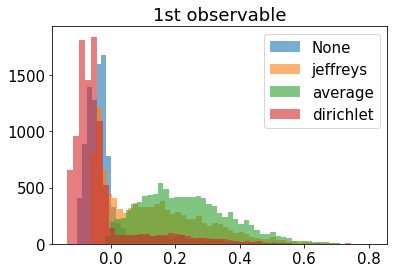

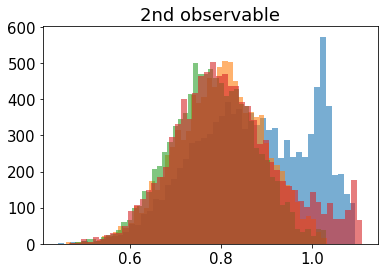

In [77]:
plt.figure()
for wm in out.keys():
    plt.title('1st observable')
    plt.hist(out[wm][3][:, 0], bins=50, label=str(wm), alpha=0.6)

plt.legend()

plt.figure()
for wm in out.keys():
    plt.title('2nd observable')
    plt.hist(out[wm][3][:, 1], bins=50, label=str(wm), alpha=0.6)

In [74]:
av = {}
std = {}

for wm in out.keys():
    av[str(wm)] = np.mean(out[wm][3], axis=0)
    std[str(wm)] = np.std(out[wm][3], axis=0)/np.sqrt(len(out[wm][3]))

print('averages: ', av)
print('std: ', std)

order_par = (np.sum((av['jeffreys'] - av['None'])**2/(std['jeffreys']**2 + std['None']**2)))
print(order_par)

averages:  {'None': array([-0.00778721,  0.86938969]), 'jeffreys': array([0.12598957, 0.79831119]), 'average': array([0.23186585, 0.78154177]), 'dirichlet': array([-0.02764539,  0.81457413])}
std:  {'None': array([0.00099822, 0.00125037]), 'jeffreys': array([0.00156218, 0.00095276]), 'average': array([0.00137507, 0.0009272 ]), 'dirichlet': array([0.00114511, 0.00118094])}
7251.587945081742


## Giovanni's trials:
- invariance w.r.t. number of frames
- data incompatible with trajectory

In [97]:
matplotlib.rcParams['lines.linewidth'] = 2

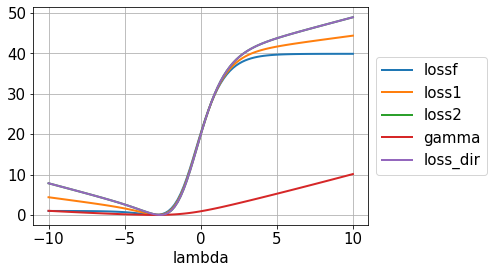

In [132]:
N = 1
P0 = np.array([3.]*N + [1.]*N)
P0 /= np.sum(P0)
g = np.array([0]*N + [1]*N)

gexp = 0.9
sigma = 0.1

lambdas = np.linspace(-10, 10, 100)

out = compute(lambdas, P0, g, gexp, sigma, alpha)

out['loss1'] = out['lossf'] - np.log(out['std_g'])
out['loss2'] = out['lossf'] - 2*np.log(out['std_g'])
out['loss_dir'] = out['lossf'] - np.log(out['dirichlet'])

for s in ['lossf', 'loss1', 'loss2', 'gamma', 'loss_dir']:
    
    out[s] -= np.min(out[s])
    plt.plot(lambdas, out[s], '-', label=s, markersize=0.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
# plt.ylim([-5, 20])
plt.grid()

- here, Dirichlet overlaps with the variance prior, indeed: $g(t) = (0, 1)$ so $\langle g \rangle = w_1$ and

$M(\lambda) = w_1^2 + \langle g \rangle^2 w_1^2 - 2\langle g \rangle w_1^2 = [w_1 (1 - w_1)]^2$

while the variance is

$\sigma^2(\lambda) = w_1 - w_1^2 = \sqrt {M(\lambda)}$.

The same happens with more than 2 frames, provided that the observables are $g(t) = (0, \dots, 0, 1, \dots, 1)$

- invariance w.r.t. number of frames:

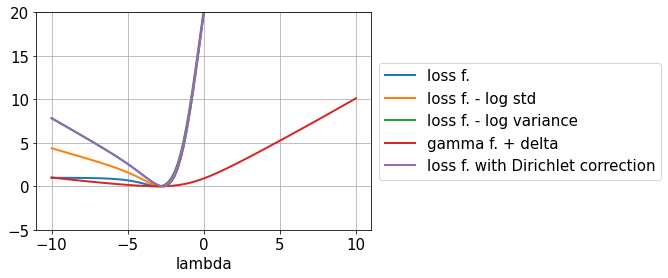

In [102]:
N = 1000
P0 = np.array([3.]*N + [1.]*N)
P0 /= np.sum(P0)
g = np.array([0]*N + [1]*N)

gexp = 0.9

out = compute(lambdas, P0, g, gexp, sigma, alpha)

loss = out['lossf']
loss1 = loss - np.log(out['std_g'])
loss2 = loss - 2*np.log(out['std_g'])
gamma = out['gamma']
loss_dir = loss - np.log(out['dirichlet'])

loss -= np.min(loss)
loss1 -= np.min(loss1)
loss2 -= np.min(loss2)
gamma -= np.min(gamma)
loss_dir -= np.min(loss_dir)

plt.plot(lambdas, loss, '-', label='loss f.')  # ,markersize=0.5)
plt.plot(lambdas, loss1, '-', label='loss f. - log std')
plt.plot(lambdas, loss2, '-', label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas, gamma, '-', label='gamma f. + delta')
plt.plot(lambdas, loss_dir, '-', label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5, 20])
plt.grid()

- data incompatible with trajectory

In [133]:
N = 1
P0 = np.array([3.]*N + [1.]*N)
P0 /= np.sum(P0)
g = np.array([0]*N + [1]*N)

gexp = 1.5



out = compute(lambdas, P0, g, gexp, sigma, alpha)

loss = out['lossf']
loss1 = loss - np.log(out['std_g'])
loss2 = loss - 2*np.log(out['std_g'])
gamma = out['gamma']
loss_dir = loss - np.log(out['dirichlet'])

loss -= np.min(loss)
loss1 -= np.min(loss1)
loss2 -= np.min(loss2)
gamma -= np.min(gamma)
loss_dir -= np.min(loss_dir)

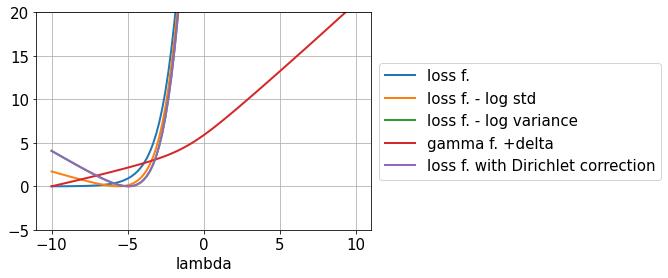

In [134]:
plt.plot(lambdas, loss, '-', label='loss f.')  #, markersize=0.5)
plt.plot(lambdas, loss1, '-', label='loss f. - log std')
plt.plot(lambdas, loss2, '-', label='loss f. - log variance')
# plt.plot(lambdas, gamma, '-', label='gamma f.')
plt.plot(lambdas, gamma, '-', label='gamma f. +delta')
plt.plot(lambdas, loss_dir, '-', label='loss f. with Dirichlet correction')

plt.legend(loc='center left',  bbox_to_anchor=(1,  0.5))
plt.xlabel('lambda')
# plt.yscale('log')
# plt.xlim([-10, 10])
plt.ylim([-5, 20])
plt.grid()

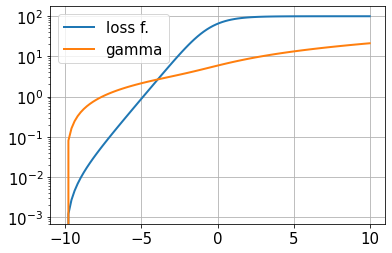

In [135]:
plt.plot(lambdas, loss, label='loss f.')
plt.plot(lambdas, gamma, label='gamma')
plt.yscale('log')
plt.legend()
plt.grid()


In [136]:
xmin_loss = lambdas[np.argwhere(loss==np.min(loss))[0][0]]
xmin_gamma = lambdas[np.argwhere(gamma==np.min(gamma))[0][0]]
xmin_1 = lambdas[np.argwhere(loss1==np.min(loss1))[0][0]]
xmin_2 = lambdas[np.argwhere(loss2==np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ',xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)

min. of the "original" loss function:  -10.0
min. of Gamma function:  -10.0
min. of the loss f. with std correction:  -5.555555555555555
min. of the loss f. with variance correction:  -4.94949494949495


### coarse graining

In [137]:
P0s = [np.array([1/3, 2/3]), np.array([1/3, 1/3, 1/3]), np.array([1/3, 0, 2/3])]  # normalized
g2p = np.array([1, 2])
g3p = np.array([1, 2, 2])
gs = [g2p, g3p, g3p]

gexp = 0.9

In [144]:
Srels = []

for i in range(len(P0s)):
    Srels.append(compute(lambdas, P0s[i], gs[i], gexp, sigma, alpha)['Srel'])

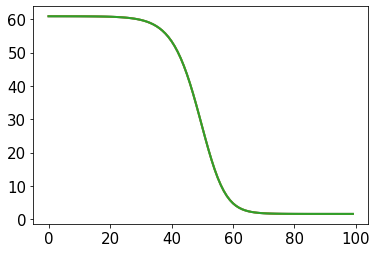

In [143]:
for Srel in Srels:
    plt.plot(Srel, '-')